## AWS Public Sector Machine Learning Workshop

**Predicting fraudulent Medicare providers using XGBoost**

---

Since 2003, the US federal government has made approximately $\$$1.7 trillion in improper payments, with an estimated $\$$206 billion made in FY 2020 alone. Improper payments are now anticipated to increase proportionally to new levels of federal spending, from the $\$$1 trillion infrastructure bill, to the anticipated $\$$3.5 trillion budget reconciliation plan

How can we go beyond basic heuristic rulesets to help agencies fight improper payments at scale? 

Using preprocessed data from the Centers for Medicare & Medicaid Services (CMS), we'll demonstrate how to train a classification model to predict fraudulent Medicare providers using the XGBoost algorithm.

**Let's get started!**

### 1. Setup
<a id=section_1_0></a>

#### 1.1 Prerequisites
<a id=section_1_1></a>

In [621]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


#### 1.2 Import packages and modules
<a id=section_1_2></a>

In [622]:
import numpy as np 
import pandas as pd
import boto3
import os
import sagemaker
import seaborn as sns
import matplotlib.pyplot as plt
import io
import sklearn
from math import sqrt
from sagemaker import get_execution_role
from sagemaker import RandomCutForest
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.datasets import dump_svmlight_file  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import dump_svmlight_file   
from collections import Counter
from sagemaker.s3 import S3Downloader

%matplotlib inline

#### 1.3 Global config settings
<a id=section_1_3></a>

In [623]:
# Allow viewing of all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1.4 Global config variables
<a id=section_1_4></a>

In [624]:
# Get IAM role and SakeMaker session
role = get_execution_role()
session = sagemaker.Session()

# Set service clients
s3_client = boto3.client('s3')
#sm_client = boto3.client('sagemaker')
#smr_client = boto3.client('sagemaker-runtime')

# S3 settings
bucket = session.default_bucket() # Update as needed
prefix = 'fraud-detect-demo' # Update as needed

### 2. Exploratory Data Analysis
<a id=section_2_0></a>

#### 2.1 Unzipping the prepocessed data file
<a id=section_2_1></a>

In [625]:
#!gzip -d processed_data_classification.csv.gz

#### 2.2 Read the preprocessed medicare data
<a id=section_2_2></a>

In [626]:
data = pd.read_csv('processed_data_classification_v2.csv', delimiter=',')

#### 2.3 View the dimensions of the dataset (#rows, #cols)
<a id=section_2_3></a>

In [627]:
data.shape

(5500, 50)

#### 2.4 Visually inspect the first few rows in the dataset
<a id=section_2_4></a>

In [628]:
data.head()

,fraudulent_provider,female,tot_suplrs_standard_deviation,tot_suplrs_mean,tot_suplrs_sum,tot_suplr_benes_standard_deviation,tot_suplr_benes_mean,tot_suplr_benes_sum,tot_suplr_clms_standard_deviation,tot_suplr_clms_mean,tot_suplr_clms_sum,tot_suplr_srvcs_standard_deviation,tot_suplr_srvcs_mean,tot_suplr_srvcs_sum,avg_suplr_sbmtd_chrg_standard_deviation,avg_suplr_sbmtd_chrg_mean,avg_suplr_sbmtd_chrg_sum,avg_suplr_mdcr_pymt_amt_standard_deviation,avg_suplr_mdcr_pymt_amt_mean,avg_suplr_mdcr_pymt_amt_sum,bene_unique_cnt_mean,bene_unique_cnt_sum,bene_unique_cnt_standard_deviation,line_svc_cnt_mean,line_svc_cnt_sum,line_svc_cnt_standard_deviation,bene_day_srvc_cnt_mean,bene_day_srvc_cnt_sum,bene_day_srvc_cnt_standard_deviation,average_submitted_chrg_amt_mean,average_submitted_chrg_amt_sum,average_submitted_chrg_amt_standard_deviation,average_medicare_payment_amt_mean,average_medicare_payment_amt_sum,average_medicare_payment_amt_standard_deviation,total_claim_count_mean,total_claim_count_sum,total_claim_count_standard_deviation,total_30_day_fill_count_mean,total_30_day_fill_count_sum,total_30_day_fill_count_standard_deviation,total_day_supply_mean,total_day_supply_sum,total_day_supply_standard_deviation,total_drug_cost_mean,total_drug_cost_sum,total_drug_cost_standard_deviation,bene_count_mean,bene_count_sum,bene_count_standard_deviation
0,0,0,0,2,12,0,5,30,8,26,157,8,26,157,221.545084,281.291774,1687.750642,40.267402,51.756601,310.539608,61,2019,45,87,2894,97,87,2894,97,612.122842,20200.053790,276.195300,83.302926,2748.996574,33.577014,16,872,5,16.739623,887.2,6.144614,358,19016,225,679.101887,35992.40,1257.721840,7,400,4
1,0,1,3,4,390,8,11,1090,43,45,4214,1673,733,68183,648.536077,205.158603,19079.750090,126.268278,37.013509,3442.256332,74,13133,59,306,54166,457,199,35224,241,76.912131,13613.447170,65.999303,17.927735,3173.209053,21.273936,46,48942,53,62.092727,64886.9,75.053557,1709,1786163,2203,2399.843091,2507836.03,4524.335169,12,13508,14
2,0,1,4,4,290,5,7,423,20,25,1508,1745,706,41682,96.672171,79.101150,4666.967838,26.030407,21.551856,1271.559511,33,1128,25,67,2287,78,67,2287,78,133.688857,4545.421138,56.698190,67.149802,2283.093266,36.452336,50,48262,55,66.317066,63730.7,79.181677,1929,1854601,2389,2151.969084,2068042.29,4477.550876,11,11119,11
3,0,0,1,1,41,2,6,128,7,19,400,8,21,452,1483.976776,958.574271,20130.059680,879.222640,516.165752,10839.480790,130,31506,145,171,41456,232,160,38869,228,309.875494,74989.869460,326.187181,91.143027,22056.612430,79.139884,78,36671,101,175.826882,81759.5,255.800821,5220,2427675,7657,5472.788065,2544846.45,19909.428210,24,11364,32
4,0,0,4,4,333,9,9,677,25,35,2432,496,226,15402,168.249662,123.252361,8381.160563,53.286680,31.118151,2116.034257,83,11828,96,130,18498,218,129,18421,219,128.802917,18290.014170,158.839433,55.376012,7863.393671,59.656966,59,74114,71,100.573899,125616.8,148.234033,2858,3570133,4448,3955.478335,4940392.44,7644.742211,15,19910,18


#### 2.5 Check data for any nulls
<a id=section_2_5></a>

In [629]:
data.isnull().values.any()

False

#### 2.6 Check for imbalance
<a id=section_2_6></a>

Review the target (fraudulent_provider) value counts to check for imbalance

In [630]:
data['fraudulent_provider'].value_counts()

0    5000
1     500
Name: fraudulent_provider, dtype: int64

We see that the majority of data is non-fraudulent. We will need to rebalance the data using sampling techniques that are designed specifically for imbalanced problems to improve the performance of the model.We use the Random Under Sampler and Over Sampling techniques from imblearn to do this (http://glemaitre.github.io/imbalanced-learn/api.html)

#### 2.7 Display correlation matix
<a id=section_2_7></a>

<AxesSubplot:>

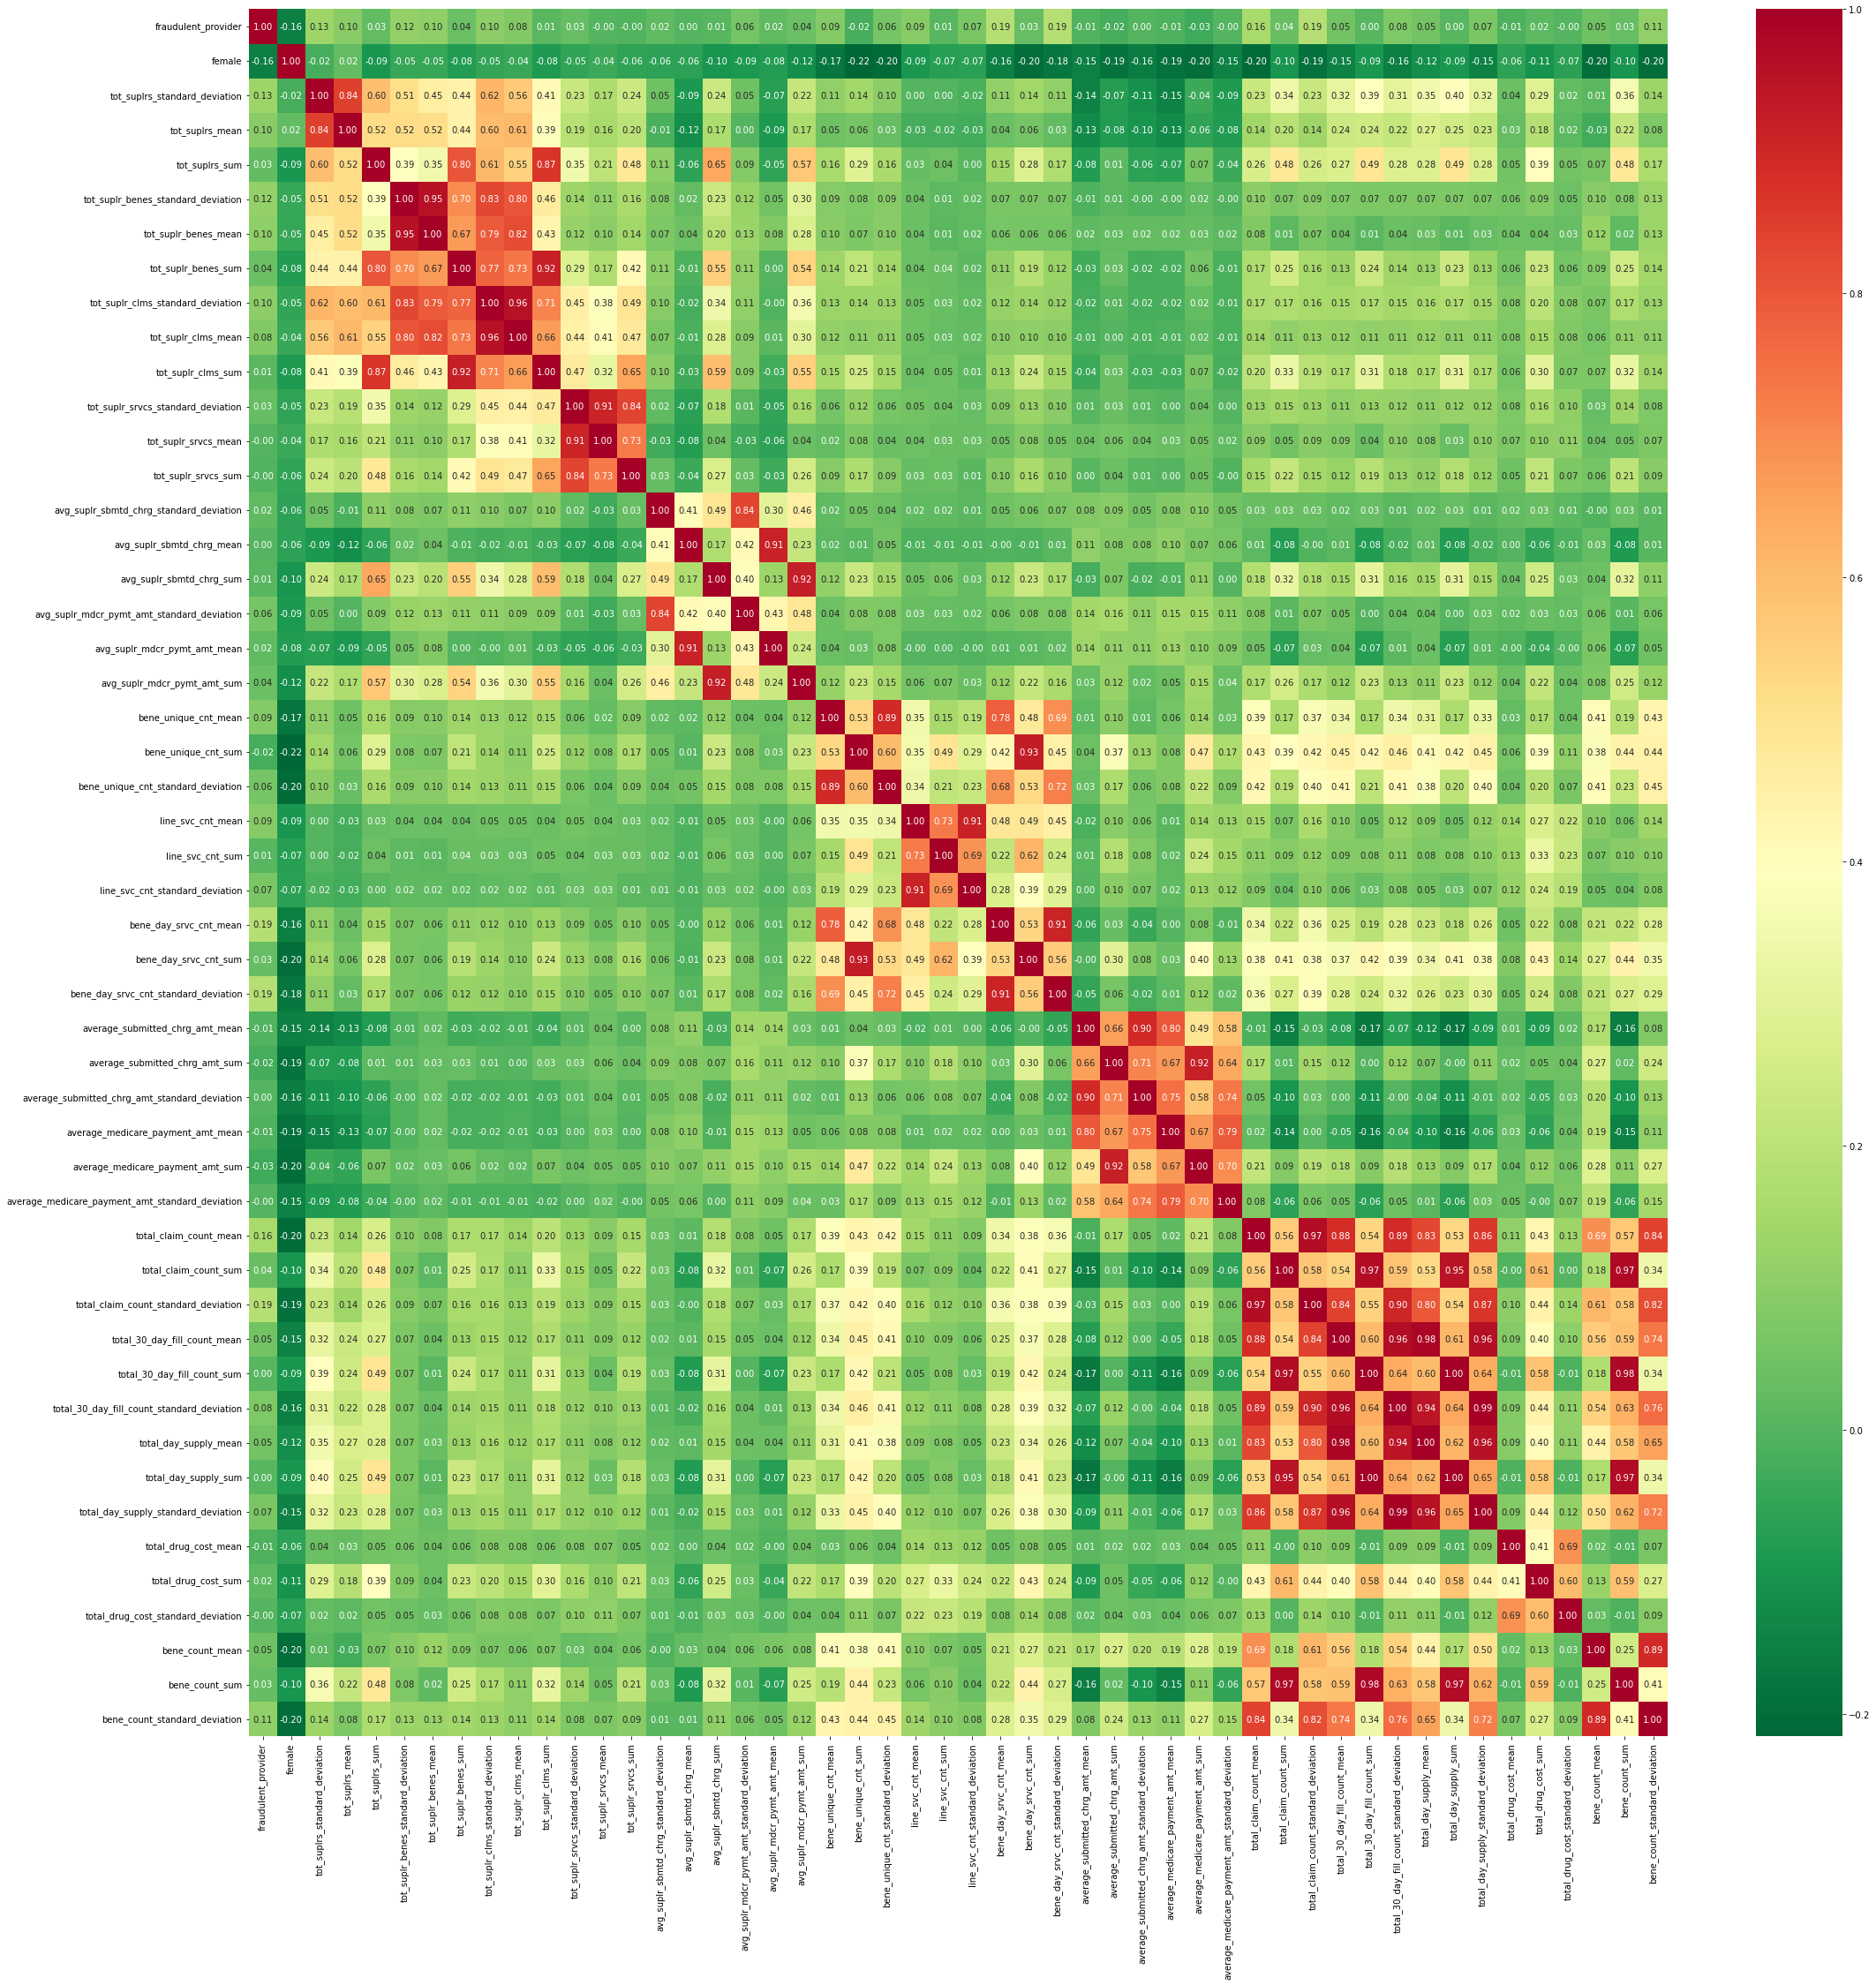

In [631]:
fig = plt.figure(figsize=(36, 36))
sns.heatmap(data.corr(), annot = True, fmt = '.2f', cmap='RdYlGn_r')

### 3. Preprocessing
<a id=section_3_0></a>

#### 3.1 Data Preparation
<a id=section_3_1></a>

Remove column headers from dataset as SageMaker does not need headers for processing csv files

In [632]:
# Removing column headers from CSV file
feature_columns = data.columns[1:]
label_column = data.columns[0]

# Setting the datatype to float32
features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Split the dataset into a train and test to evaluate the performance of our models. Since the data is highly imbalanced, it is important to stratify across the data sets to ensure an even distribution.

In [633]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, stratify=labels)

#### 3.2 Applying SMOTE
<a id=section_3_2></a>

The ratio in oversampling and the sampling strategy for undersampling are very important in improving the performance of the models. We have selected ratios based ased on research from https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0225-0 for this dataset. However, try to expirement with different ratios to see the impact

In [634]:
# Oversample the minority class with SMOTE to a 1:4 ratio
over = SMOTE(sampling_strategy=0.25)

# Undersample the majority class to achieve about a 1:1 ratio.
# The minority class will be the same amount (1 to 1) as the majority class
under = RandomUnderSampler(sampling_strategy=1)

# Add steps to parameter list
steps = [('o', over), ('u', under)]

# Create imblearn.pipeline and pass steps
pipeline = Pipeline(steps=steps)

# Fit and apply to the CMS dataset in a single transform
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

#### 3.3 Check for imbalance
<a id=section_3_3></a>

Review the target (fraudulent_provider) value counts to check for imbalance

In [635]:
print(sorted(Counter(y_smote).items()))

[(0.0, 1125), (1.0, 1125)]


#### 3.4 Split SMOTE augmented dataset
<a id=section_3_4></a>

In [636]:
X_smote_train, X_smote_validation, y_smote_train, y_smote_validation = train_test_split(
    X_smote, y_smote, test_size=0.1, stratify=y_smote)

#### 3.5 Prepare training data for uploading
<a id=section_3_5></a>

We first copy the data to an in-memory buffer and then upload the data to S3 in libsvm format (XGBoost can take either libsvm or csv files as input)

In [637]:
# Use an in-memory buffer instead of a file
buf = io.BytesIO()

# Transform the dataset in libsvm/svmlight file format
sklearn.datasets.dump_svmlight_file(X_smote_train, y_smote_train, buf)

# Set pointer to the beginning of the file
buf.seek(0);

#### 3.6 Upload training data to S3
<a id=section_3_6></a>

In [638]:
# Set the directory path in S3
key = 'fraud-dataset'
subdir = 'base'

In [639]:
# Upload data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(buf)

# Display the S3 training data location
s3_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/train/base/fraud-dataset
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/output


#### 3.7 Prepare validation data for uploading
<a id=section_3_7></a>

In [640]:
# Use an in-memory buffer instead of a file
buf = io.BytesIO()

# Transform the dataset in libsvm/svmlight file format
sklearn.datasets.dump_svmlight_file(X_smote_validation, y_smote_validation, buf)

# Set pointer to the beginning of the file
buf.seek(0);

#### 3.8 Upload validation data to S3
<a id=section_3_8></a>

In [641]:
# Upload data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', subdir, key)).upload_fileobj(buf)

# Display the S3 validation data location
s3_validation_data = 's3://{}/{}/validation/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded validation data location: {}'.format(s3_validation_data))

Uploaded validation data location: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/validation/base/fraud-dataset


### 4. Model Training
<a id=section_4_0></a>

#### 4.1 Get the container URI for running XGBoost
<a id=section_4_1></a>

We will use the Amazon XGBoost supervised learning algorithm for classifcation

In [642]:
# Retrieves the ECR URI for the pre-built SageMaker XGBoost Docker image
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")

SageMaker abstracts training via Estimators. We can pass the classifier and parameters along with hyperparameters to the estimator, and fit the estimator to the data in S3. An important parameter here is `scale_pos_weight` which scales the weights of the positive vs. negative class examples. This is crucial to do in an imbalanced dataset like the one we are using here, otherwise the majority class would dominate the learning.

The other hyperparameters seen here were based on the results of the Hyperparameter Optimization performed using SageMaker. We describe that technique in the next section of this notebook

#### 4.2 Rebalance positive and negative weights
<a id=section_4_2></a>

In [643]:
# Because the data set is so highly skewed, we set the scale position weight conservatively,
# as sqrt(num_nonfraud/num_fraud).
# Other recommendations for the scale_pos_weight are setting it to (num_nonfraud/num_fraud).
scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

In [644]:
scale_pos_weight

3.1622776601683795

#### 4.3 Train the model
<a id=section_4_3></a>

Estimators are a high level interface for SageMaker training for handling end-to-end Amazon SageMaker training and deployment tasks.

In [645]:
%%time

hyperparams = {
    "max_depth":7,
    "subsample":0.8,
    "num_round":145,
    "eta":0.82,
    "gamma":4,
    "min_child_weight":41.08,
    "silent":0,
    "objective":'binary:logistic',
    "eval_metric":'auc',
    "scale_pos_weight": scale_pos_weight
}

clf = sagemaker.estimator.Estimator(container,
                                    get_execution_role(),
                                    hyperparameters=hyperparams,
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)


clf.fit({'train': s3_train_data, 'validation': s3_validation_data })

2022-10-03 13:09:21 Starting - Starting the training job...ProfilerReport-1664802561: InProgress
...
2022-10-03 13:10:11 Starting - Preparing the instances for training.........
2022-10-03 13:11:35 Downloading - Downloading input data...
2022-10-03 13:12:15 Training - Downloading the training image........Arguments: train
[2022-10-03:13:13:29:INFO] Running standalone xgboost training.
[2022-10-03:13:13:29:INFO] File size need to be processed in the node: 3.91mb. Available memory size in the node: 8784.4mb
[13:13:29] S3DistributionType set as FullyReplicated
[13:13:29] 6975x49 matrix with 325964 entries loaded from /opt/ml/input/data/train
[13:13:29] S3DistributionType set as FullyReplicated
[13:13:29] 225x49 matrix with 10518 entries loaded from /opt/ml/input/data/validation
[13:13:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=7
[0]#011train-auc:0.862884#011validation-auc:0.784371
[13:13:29] src/tree/updater_prune.cc:74: tree pru

### 5. Model Hosting
<a id=section_5_0></a>

#### 5.1 Create a real-time inference endpoint
<a id=section_5_1></a>

Now we deploy the estimator to an endpoint.

In [646]:
%%time
# Serialize data to a CSV-formatted string
csv_serializer = CSVSerializer()

# Create a real-time inference endpoint that hosts our trained model 
xgb_predictor = clf.deploy(initial_instance_count=1,
                       instance_type='ml.m4.xlarge', 
                       serializer=csv_serializer)

-------!CPU times: user 99.9 ms, sys: 4.78 ms, total: 105 ms
Wall time: 3min 31s


### 6. Model Evaluation
<a id=section_6_0></a>

Once we have trained the model we can use it to make predictions for the test set.

#### 6.1 Create a wrapper function for model testing
<a id=section_6_1></a>

In [647]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, df, rows=500):
    """
    A wrapper function to invoke the Estimator's predict function using
    a for loop. 
    
    Parameters:
        current_predictor: The sagemaker.estimator.Estimator object
        df: a DataFrame object containing observations without the target feature
        rows: number of observations passed to the predict function per batch
      
    Returns:
        predictions: An array of predictions (of dtype float64)
    """
    
    # Split an array into multiple sub-arrays by dividing num of observations by rows parameter
    split_array = np.array_split(df, int(df.shape[0] / float(rows) + 1))
    
    # Initialize variable to store prediction results
    predictions = ''
    
    # Call the Estimator's predict function
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    # Return
    return np.fromstring(predictions[1:], sep=',')

#### 6.2 Test the model
<a id=section_6_2></a>

In [648]:
%%time
# Test the model by invoking the real-time inference endpoint with observations from the test dataset
raw_preds = predict(xgb_predictor, X_test)

CPU times: user 27.7 ms, sys: 3.69 ms, total: 31.4 ms
Wall time: 183 ms


#### 6.3 Calculate balanced accuracy scores
<a id=section_6_3></a>

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

We will use [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

We can bring a balance between the metrics again by adjusting our classification threshold (threshold between labeling a point as fraud or not). We can try different thresholds to see if they affect the result of the classification.

In [649]:
# Calculate balanced accuracy scores for different threshold values
proposed_treshold = 0.0
proposed_score = 0.0

for thres in np.linspace(0.1, 0.99, num=10):
    smote_thres_preds = np.where(raw_preds > thres, 1, 0)
    score = balanced_accuracy_score(y_test, smote_thres_preds)
    print("Threshold: {:.1f}".format(thres))
    print("Balanced accuracy = {:.3f}".format(score))
    
    # Set the max score    
    if proposed_score <= score:
        proposed_score = score
        proposed_treshold = thres

Threshold: 0.1
Balanced accuracy = 0.820
Threshold: 0.2
Balanced accuracy = 0.861
Threshold: 0.3
Balanced accuracy = 0.886
Threshold: 0.4
Balanced accuracy = 0.895
Threshold: 0.5
Balanced accuracy = 0.911
Threshold: 0.6
Balanced accuracy = 0.918
Threshold: 0.7
Balanced accuracy = 0.917
Threshold: 0.8
Balanced accuracy = 0.910
Threshold: 0.9
Balanced accuracy = 0.862
Threshold: 1.0
Balanced accuracy = 0.669


In [650]:
# use the best thresholds from the above
y_preds = np.where(raw_preds >= proposed_treshold, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))

Balanced accuracy = 0.9179999999999999


#### 6.4 Plot results in a confusion matrix
<a id=section_6_4></a>

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [651]:
def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

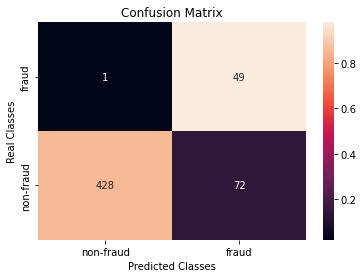

In [652]:
plot_confusion_matrix(y_test, y_preds)

#### 6.5 Display Classification Report
<a id=section_6_5></a>

In [654]:
print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      0.86      0.92       500
       fraud       0.40      0.98      0.57        50

    accuracy                           0.87       550
   macro avg       0.70      0.92      0.75       550
weighted avg       0.94      0.87      0.89       550



In [655]:
# Classification Report transposed 
df_classification_report_smote = pd.DataFrame(
    classification_report(y_test, 
                          y_preds, 
                          target_names=['non-fraud', 'fraud'], 
                          output_dict=True)).T

df_classification_report_smote['support'] = df_classification_report_smote.support.apply(int)

df_classification_report_smote

,precision,recall,f1-score,support
non-fraud,0.997669,0.856000,0.921421,500
fraud,0.404959,0.980000,0.573099,50
accuracy,0.867273,0.867273,0.867273,0
macro avg,0.701314,0.918000,0.747260,550
weighted avg,0.943786,0.867273,0.889755,550


#### 6.6 Training without SMOTE (Optional)
<a id=section_6_6></a>

In this section we'll perform the same training, hosting and model evaluation steps on the original dataset, then compare the classification reports between the original dataset and the SMOTE augmented dataset

In [656]:
%%time

# Converts data to SVM format and returns a in-memory buffer
def convertToSVM(X, y):
    buf = io.BytesIO()
    sklearn.datasets.dump_svmlight_file(X, y, buf)
    buf.seek(0);
    
    # Return    
    return buf


# Uploads an in-memory buffer as a file to a specified S3 location
def uploadToS3(path, buf):
    
    # Set the directory path in S3
    key = 'fraud-dataset-original'
    subdir = 'base'
    
    # Upload to S3
    boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, path, subdir, key)).upload_fileobj(buf)
    s3_input_location = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
    s3_output_location = 's3://{}/{}/{}/output'.format(bucket, prefix, key)
    
    # Return
    return (s3_input_location, s3_output_location)


# Convert datasets to SVM and load into in-memory buffer
train_svm = convertToSVM(X_train, y_train)
test_svm = convertToSVM(X_test, y_test)

# Upload training and test datasets
s3_orig_train_data, s3_output_location = uploadToS3('train', train_svm)
s3_orig_test_data, s3_output_location = uploadToS3('test', test_svm)

# We'll reuse the Estimator from above for to train
clf.output_path = s3_output_location
clf.fit({'train': s3_orig_train_data, 'validation': s3_orig_test_data })

2022-10-03 13:18:09 Starting - Starting the training job...ProfilerReport-1664803089: InProgress
...
2022-10-03 13:18:52 Starting - Preparing the instances for training.........
2022-10-03 13:20:33 Downloading - Downloading input data...
2022-10-03 13:20:57 Training - Downloading the training image......
2022-10-03 13:22:07 Training - Training image download completed. Training in progress..Arguments: train
[2022-10-03:13:22:11:INFO] Running standalone xgboost training.
[2022-10-03:13:22:11:INFO] File size need to be processed in the node: 5.04mb. Available memory size in the node: 8796.6mb
[13:22:11] S3DistributionType set as FullyReplicated
[13:22:11] 4950x49 matrix with 230907 entries loaded from /opt/ml/input/data/train
[13:22:11] S3DistributionType set as FullyReplicated
[13:22:11] 4950x49 matrix with 230907 entries loaded from /opt/ml/input/data/validation
[13:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=7
[0]#011train-

In [657]:
%%time
# Serialize data to a CSV-formatted string
csv_serializer = CSVSerializer()

# Create a real-time inference endpoint that hosts our trained model 
xgb_predictor_orig = clf.deploy(initial_instance_count=1,
                       instance_type='ml.m4.xlarge', 
                       serializer=csv_serializer)

-------!CPU times: user 89.7 ms, sys: 16.6 ms, total: 106 ms
Wall time: 3min 31s


In [658]:
%%time
# Test the model by invoking the real-time inference endpoint with observations from the test dataset
y_preds_orig = predict(xgb_predictor_orig, X_test)

CPU times: user 32.9 ms, sys: 0 ns, total: 32.9 ms
Wall time: 184 ms


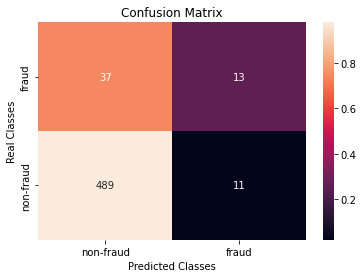

In [659]:
plot_confusion_matrix(y_test, y_preds_orig.round())

In [660]:
print(classification_report(
    y_test, y_preds_orig.round(), target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       0.93      0.98      0.95       500
       fraud       0.54      0.26      0.35        50

    accuracy                           0.91       550
   macro avg       0.74      0.62      0.65       550
weighted avg       0.89      0.91      0.90       550



In [661]:
# Classification Report transposed 
df_classification_report_orig = pd.DataFrame(
    classification_report(y_test, 
                          y_preds_orig.round(), 
                          target_names=['non-fraud', 'fraud'], 
                          output_dict=True)).T

df_classification_report_orig['support'] = df_classification_report_orig.support.apply(int)

df_classification_report_orig

,precision,recall,f1-score,support
non-fraud,0.929658,0.978000,0.953216,500
fraud,0.541667,0.260000,0.351351,50
accuracy,0.912727,0.912727,0.912727,0
macro avg,0.735662,0.619000,0.652284,550
weighted avg,0.894386,0.912727,0.898501,550


In [662]:
# Compare the original (no SMOTE) and SMOTE classification reports
df_classification_report_orig.compare(df_classification_report_smote, align_axis=0).rename(index={'self': 'No SMOTE', 'other': 'SMOTE'})

precision    recall  f1-score
non-fraud    No SMOTE   0.929658  0.978000  0.953216
             SMOTE      0.997669  0.856000  0.921421
fraud        No SMOTE   0.541667  0.260000  0.351351
             SMOTE      0.404959  0.980000  0.573099
accuracy     No SMOTE   0.912727  0.912727  0.912727
             SMOTE      0.867273  0.867273  0.867273
macro avg    No SMOTE   0.735662  0.619000  0.652284
             SMOTE      0.701314  0.918000  0.747260
weighted avg No SMOTE   0.894386  0.912727  0.898501
             SMOTE      0.943786  0.867273  0.889755

Given that the CMS dataset is **highly imbalanced** and the objective of the model is to correctly identify **fradulent** transactions (minority class), we will focus on the **recall** and **f-1 metrics** for evaluating model performance. By applying SMOTE to the minority class and RandomUnderSampler to the majority class, the recall score increased from .26 to .98. Additionally, the f1-score improved from .35 to .57. Interestingly, the precision score decreased from .54 to .40 for the minority class, but increased from .93 to .99 for the majority class.

## Clean up

In [663]:
# Uncomment to clean up endpoints
# xgb_predictor.delete_endpoint()
# xgb_predictor_orig.delete_endpoint()

## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed from CMS 

https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service

